# Import Libraries

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter


In [73]:
torch.cuda.is_available()

True

In [74]:
#3x3 convolution with padding"

def conv3x3(in_planes, out_planes, stride=1):
    
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [75]:
class BasicBlock(nn.Module):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_chan, out_chan,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
            )

    def forward(self, x):
        residual = self.conv1(x)
        residual = F.relu(self.bn1(residual))
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out




In [76]:
def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    layers = [BasicBlock(in_chan, out_chan, stride=stride)]
    for i in range(bnum-1):
        layers.append(BasicBlock(out_chan, out_chan, stride=1))
    return nn.Sequential(*layers)

In [77]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)
        self.init_weight()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x)  # 1/8
        feat16 = self.layer3(feat8)  # 1/16
        feat32 = self.layer4(feat16)  # 1/32
        return feat8, feat16, feat32

    def init_weight(self):
        state_dict = torch.load('models/resnet18-5c106cde.pth')
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            if 'fc' in k:
                continue
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module,  nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

In [78]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                              out_chan,
                              kernel_size=ks,
                              stride=stride,
                              padding=padding,
                              bias=False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.bn(x))
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)


In [79]:
class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(
            mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(
            out_chan, out_chan, kernel_size=1, bias=False)
        self.bn_atten = nn.BatchNorm2d(out_chan)
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

In [80]:
class ContextPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        self.resnet = Resnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]
        feat8, feat16, feat32 = self.resnet(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])
        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

In [81]:
# This is not used, since I replace this with the resnet feature with the same size
class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params
    
class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                               out_chan//4,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.conv2 = nn.Conv2d(out_chan//4,
                               out_chan,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

In [82]:
class BiSeNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(BiSeNet, self).__init__()
        self.cp = ContextPath()
        # here self.sp is deleted
        self.ffm = FeatureFusionModule(256, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]
        feat_res8, feat_cp8, feat_cp16 = self.cp(
            x)  # here return res3b1 feature
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm(feat_sp, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(
            feat_out, (H, W), mode='bilinear', align_corners=True)
        feat_out16 = F.interpolate(
            feat_out16, (H, W), mode='bilinear', align_corners=True)
        feat_out32 = F.interpolate(
            feat_out32, (H, W), mode='bilinear', align_corners=True)
        return feat_out, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, FeatureFusionModule) or isinstance(child, BiSeNetOutput):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


# TEST

In [83]:
model = BiSeNet(n_classes=19)
model.load_state_dict(torch.load("models/79999_iter.pth", map_location=torch.device('cuda')))
model.eval();

In [84]:
def parse(img):
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    l = 512
    with torch.no_grad():
        img = img.resize((l,l), Image.BILINEAR)
        inp = to_tensor(img)
        out = model(torch.unsqueeze(inp, 0))[0]
        out = out.squeeze(0).cpu().numpy().argmax(0)
    return np.array(img), out

In [85]:
def calc_shift(m0, m1):
    mu = cv2.moments(m0, True)
    x0, y0 = int(mu["m01"]/mu["m00"]), int(mu["m10"]/mu["m00"])

    mu = cv2.moments(m1, True)
    x1, y1 = int(mu["m01"]/mu["m00"]), int(mu["m10"]/mu["m00"])
    return (x0-x1, y0-y1)

In [86]:
def swap_parts(i0, i1, m0, m1, labels):
    m0 = create_mask(m0, labels)
    m1 = create_mask(m1, labels)
    i,j = calc_shift(m0, m1)
    l = i0.shape[0]
    h0 = i0 * m0.reshape((l,l,1)) # forground
    y = np.zeros((l,l,3))
    if i>=0 and j>= 0:
        y[:l-i, :l-j] += h0[i:, j:]
    elif i>=0 and j<0:
        y[:l-i, -j:] += h0[i:, :l+j]
    elif i<0 and j>=0:
        y[-i:, :l-j] += h0[:l+i, j:]
    else:
        y[-i:, -j:] += h0[:l+i, :l+j]

    h1 = i1 * (1-m1).reshape((l,l,1)) # background
    b = cv2.morphologyEx(m1.astype('uint8'), cv2.MORPH_GRADIENT, np.ones((5,5)).astype('uint8') )
    c = (np.sum(i1*b.reshape((l,l,1)), axis=(0,1)) / np.sum(b)).astype(int)
    # fill color in the hole
    h1 += c * m1.reshape((l,l,1)) 
    y += h1 * (y==0)

    return y

In [87]:
def create_mask(m, labels):
    mask = np.zeros_like(m)
    for label in labels:
        mask += (m == label)
    mask = (mask>0).astype(int)
    return mask

In [88]:
def swap(i0, i1):
    # left eyebrow, right eybrow, left eye, right eye, nose, mouth
    parts = [[2], [3], [4], [5], [10], [11,12,13]]
    i0, m0 = parse(i0)
    i1, m1 = parse(i1)
    for part in parts:
        i1 = swap_parts(i0, i1, m0, m1, part)
    return i1

In [89]:
def concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# Result

Wall time: 1.66 s


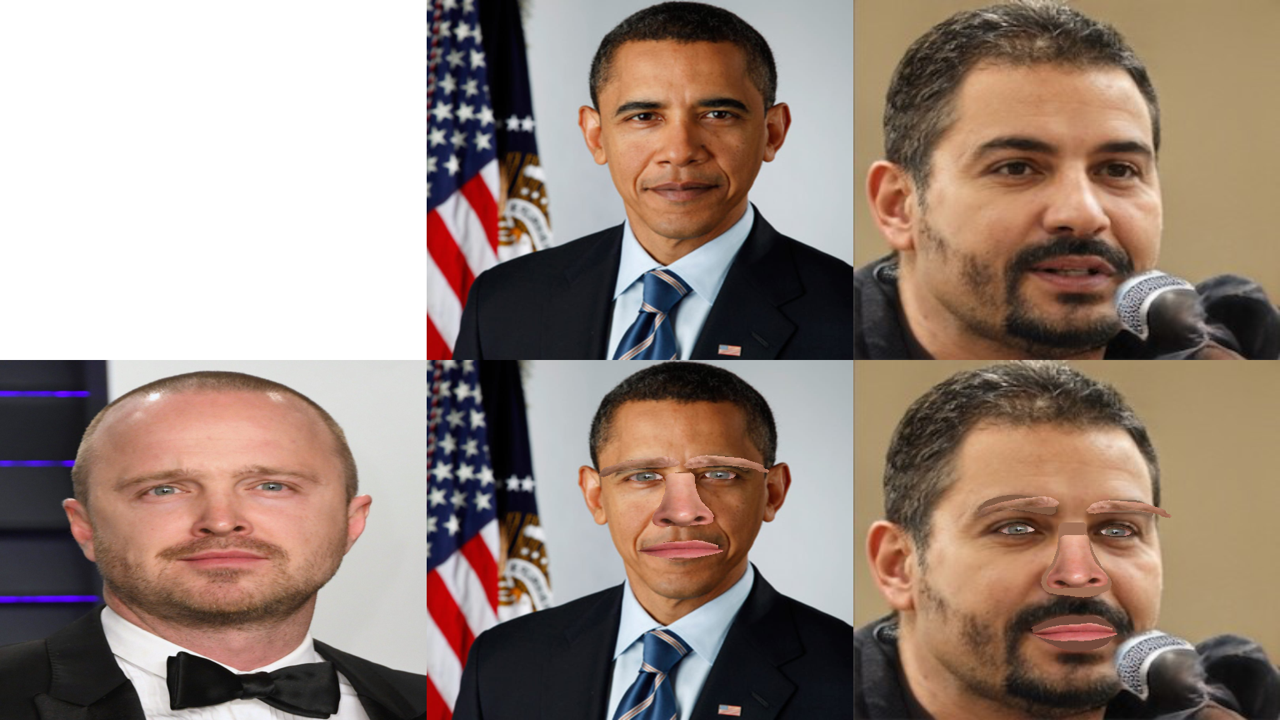

In [98]:
%%time
img0 = Image.open("photos/5.jpg").resize((512,512), Image.BILINEAR)
img1 = Image.open("photos/1.jpg").resize((512,512), Image.BILINEAR)
img2 = Image.open("photos/2.jpg").resize((512,512), Image.BILINEAR)

out1 = Image.fromarray(swap(img0, img1).astype('uint8'))
out2 = Image.fromarray(swap(img0, img2).astype('uint8'))

upper = concat_h(Image.fromarray(np.ones((512,512), np.uint8)*255), concat_h(img1, img2))

lower = concat_h(img0, concat_h(out1, out2))
res = concat_v(upper, lower)
res.resize(((1280,720)))